# Procesamiento de imágenes digitales (Ecualización del histograma)


Importar librerias requeridas

In [1]:
import numpy as np
import scipy.signal
import cv2 as cv
from matplotlib import pyplot as plt
from PIL import Image

Importar imagen para hacer las pruebas (en escala de grises o color)
https://github.com/hfarueda/DIP/blob/main/Imagenes/


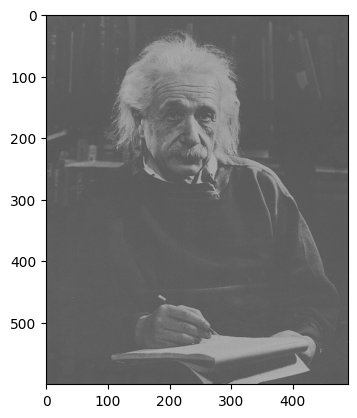

In [2]:
image = cv.imread('../resources/images/histogram_equalization/Einstein_2_lowcontrast.tif')
plt.imshow(image)
plt.show()

# Ecualización del Histograma


In [3]:
# Convertir y dividir la imagen LAB (Luminance = Lightness) L es como calcular la media de los 3 canales
lab_img = cv.cvtColor(image, cv.COLOR_BGR2LAB)
l, a, b = cv.split(lab_img)

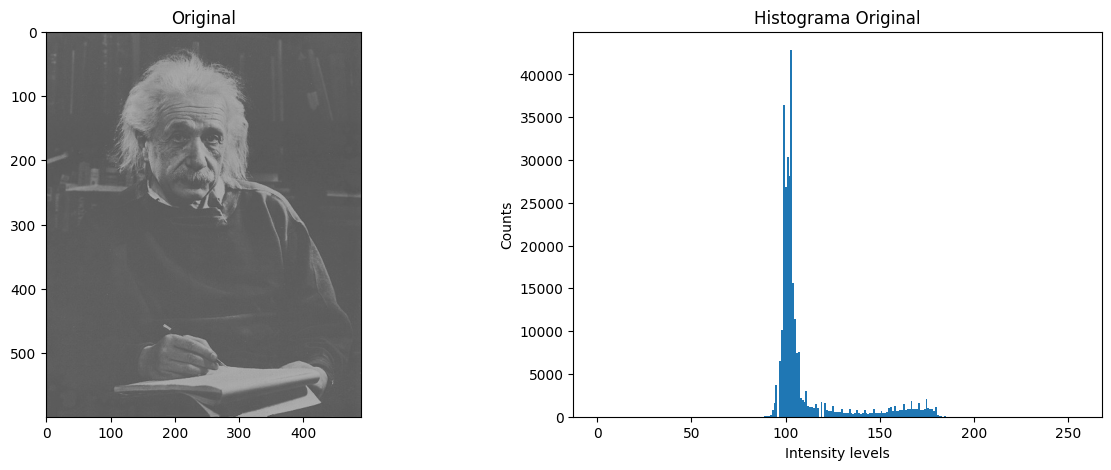

In [4]:
# Mostrar imagen original de luminancia y su histograma
plt.figure(figsize=(15,5))
plt.subplot(121), plt.imshow(image), plt.title('Original');
plt.subplot(122), plt.hist(l.ravel(), bins=256, range=(0,255)); plt.xlabel('Intensity levels'); plt.ylabel('Counts'); plt.title('Histograma Original');

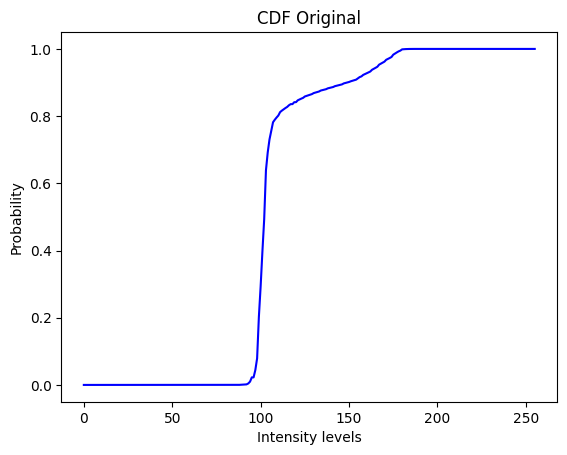

In [5]:
# Calculemos la CDF y analicemosla
hist, bins = np.histogram(l.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_norm_orig = cdf / cdf.max()
plt.plot(cdf_norm_orig, color = 'b'), plt.xlabel('Intensity levels'); plt.ylabel('Probability'); plt.title('CDF Original');
plt.show()

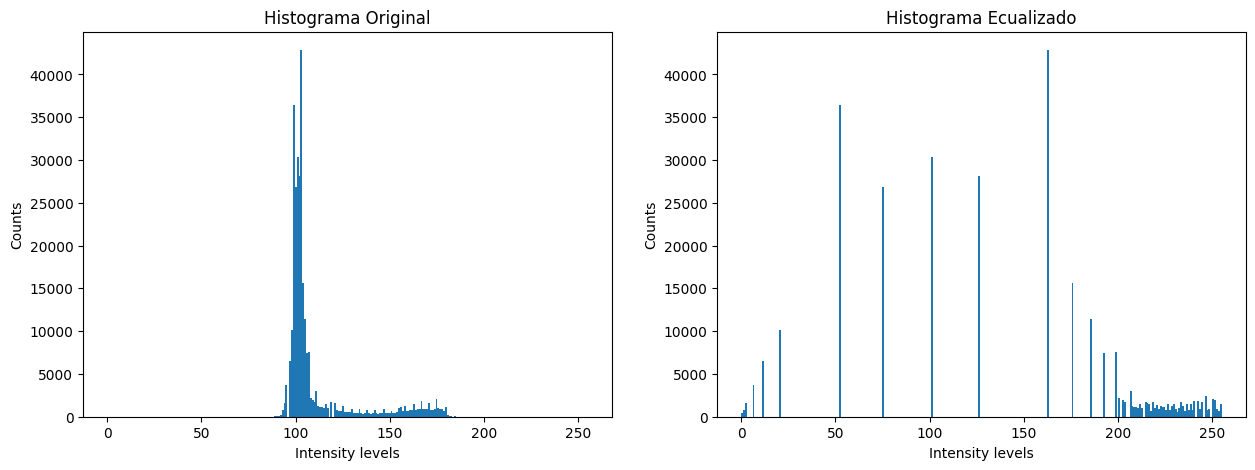

In [6]:
# Aplicar ecualización de histograma al canal L
equ = cv.equalizeHist(l)

plt.figure(figsize=(15,5))
plt.subplot(121), plt.hist(l.ravel(), bins=256, range=(0,255)); plt.xlabel('Intensity levels'); plt.ylabel('Counts'); plt.title('Histograma Original');
plt.subplot(122), plt.hist(equ.flat, bins=256, range=(0,255)), plt.xlabel('Intensity levels'); plt.ylabel('Counts'); plt.title('Histograma Ecualizado');

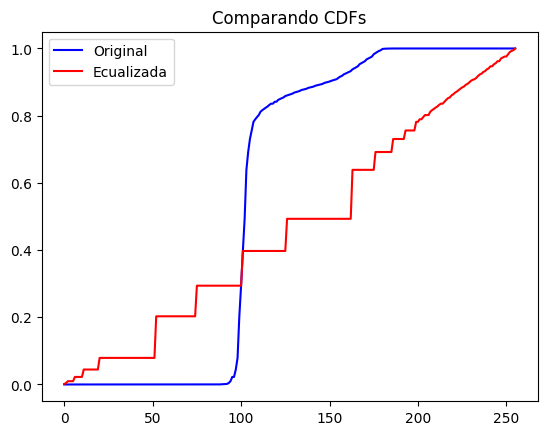

In [7]:
hist, bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_norm_eq = cdf / cdf.max()
plt.plot(cdf_norm_orig, color = 'b')
plt.plot(cdf_norm_eq, color = 'r')
plt.title('Comparando CDFs')
plt.legend(["Original", "Ecualizada"], loc="upper left")
plt.show()

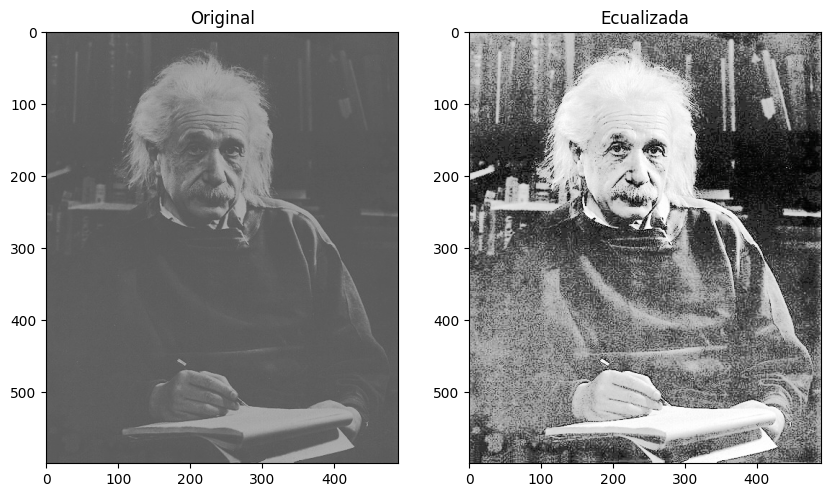

In [8]:
# Combine la imagen ecualizada con los canales a y b, y conviertala de vuelta a RGB
updated_lab_img1 = cv.merge((equ,a,b))
hist_eq_img = cv.cvtColor(updated_lab_img1, cv.COLOR_LAB2BGR)

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(image), plt.title('Original');
plt.subplot(122), plt.imshow(hist_eq_img), plt.title('Ecualizada');

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
Una mejor manera de ecualizar un histograma se logra a través de la ecualización de histograma adaptativa. En este, la imagen se divide en pequeños bloques llamados "mosaicos" (tileSize es 8x8 de forma predeterminada en OpenCV). Luego, cada uno de estos bloques se ecualiza como de costumbre. Entonces, en un área pequeña, el histograma se limitaría a una región pequeña (a menos que haya ruido). Si hay ruido, se amplificará. Para evitar esto, se aplica limitación de contraste. Si algún "bin" del histograma está por encima del límite de contraste especificado (por defecto 40 en OpenCV), esos píxeles se recortan y distribuyen uniformemente a otros "bins" antes de aplicar la ecualización del histograma. Después de la ecualización, para eliminar artefactos en los bordes de los mosaicos, se aplica la interpolación bilineal.

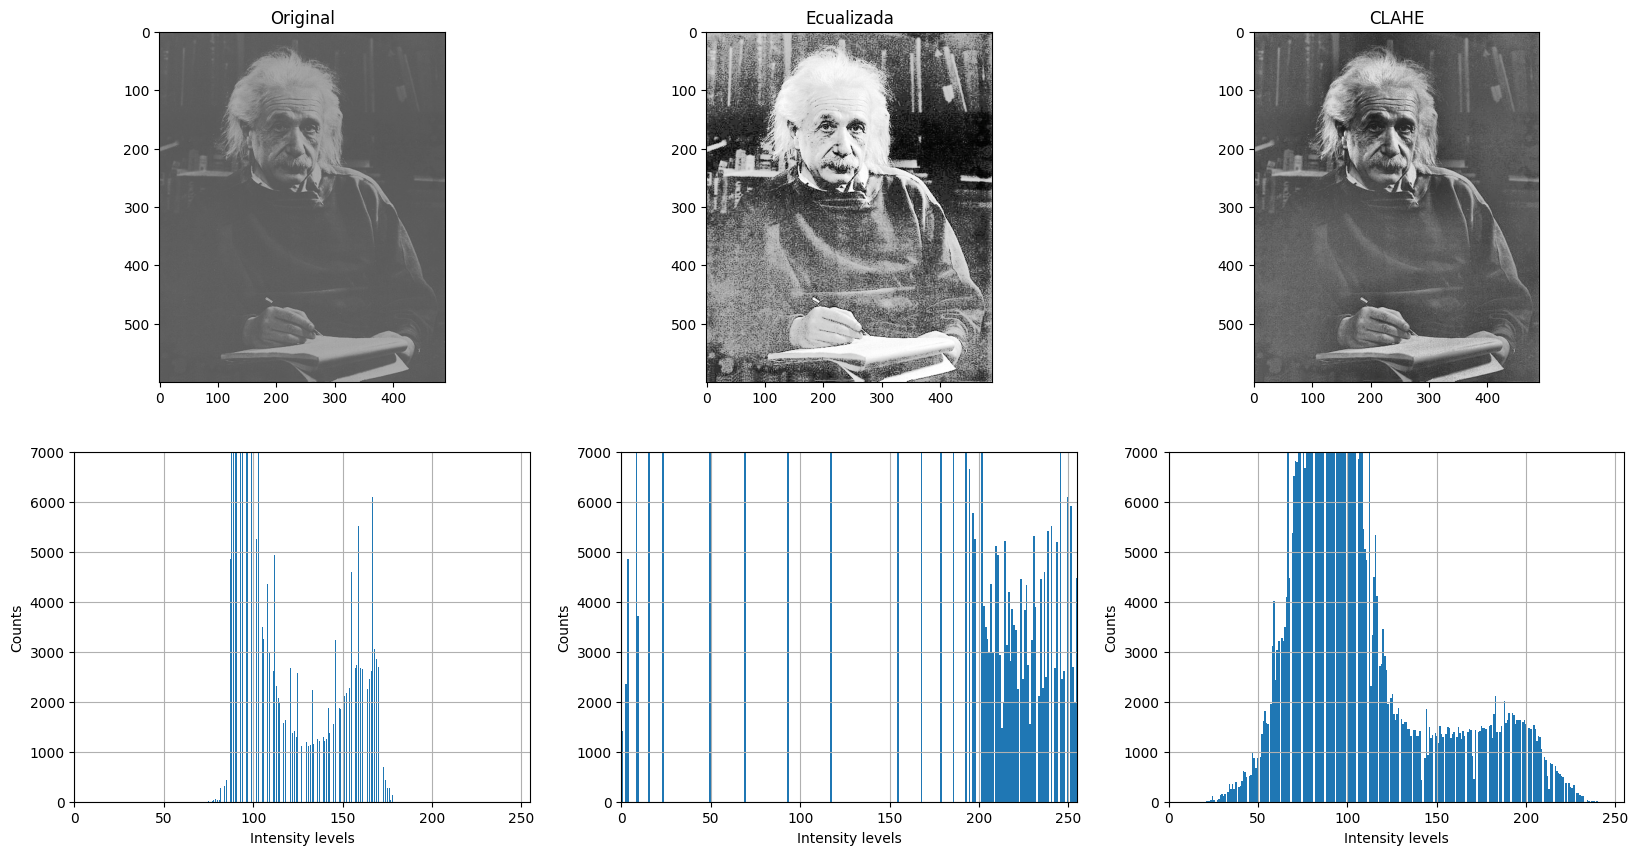

In [9]:
# Cree y aplique CLAHE al canal L
clahe = cv.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
clahe_img = clahe.apply(l)

# Recombine y convierta de vuelta a RGB
updated_lab_img2 = cv.merge((clahe_img,a,b))
CLAHE_img = cv.cvtColor(updated_lab_img2, cv.COLOR_LAB2BGR)

# Plot
plt.figure(figsize=(20,10))
plt.subplot(231), plt.imshow(image), plt.title('Original')
plt.subplot(232), plt.imshow(hist_eq_img), plt.title('Ecualizada')
plt.subplot(233), plt.imshow(CLAHE_img), plt.title('CLAHE')
plt.subplot(234), plt.hist(image.ravel(),256), plt.axis([0,255,0,7e3]), plt.grid(True); plt.xlabel('Intensity levels'); plt.ylabel('Counts');
plt.subplot(235), plt.hist(hist_eq_img.ravel(),256), plt.axis([0,255,0,7e3]), plt.grid(True); plt.xlabel('Intensity levels'); plt.ylabel('Counts');
plt.subplot(236), plt.hist(CLAHE_img.ravel(),256), plt.axis([0,255,0,7e3]), plt.grid(True); plt.xlabel('Intensity levels'); plt.ylabel('Counts');

# Reto del Notebook: Ecualización del histograma (A mano)

## Paso 0: Cargar la imagen

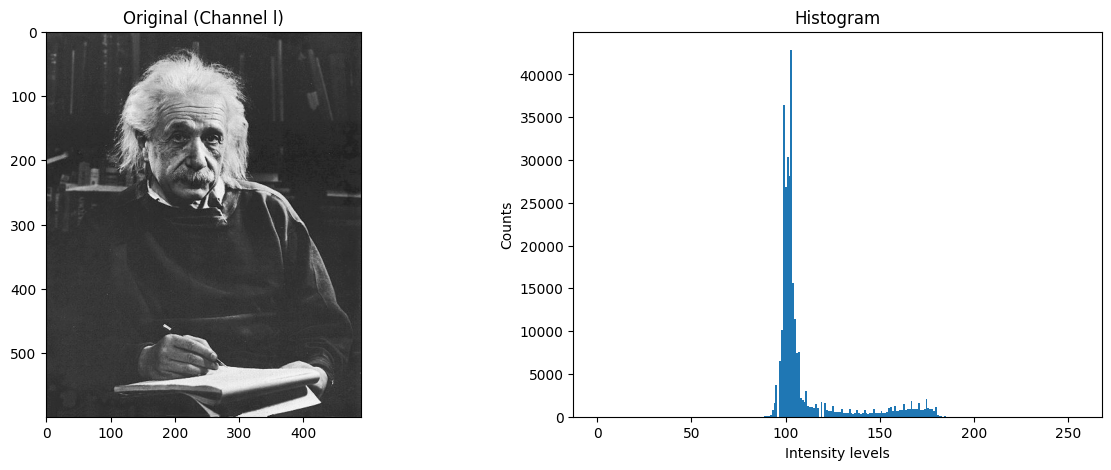

In [10]:
einstein = np.copy(l)

plt.figure(figsize=(15,5))
plt.subplot(121), plt.imshow(einstein, cmap='gray'), plt.title('Original (Channel l)');
plt.subplot(122), plt.hist(einstein.ravel(), bins=256, range=(0,255)); plt.xlabel('Intensity levels'); plt.ylabel('Counts'); plt.title('Histogram');

In [11]:
einstein_vec = np.ravel(einstein)
print(f'Dimensions: {einstein.shape}, Pixels: {einstein_vec.shape}')

Dimensions: (600, 490), Pixels: (294000,)


## Paso 1: Calcule el histograma acumulado normalizado

In [12]:
frec_einstein, bins_einstein = np.histogram(einstein_vec, 256, [0,256])

pmf_einstein = frec_einstein / einstein_vec.shape[0]
cdf_einstein = np.cumsum(pmf_einstein)

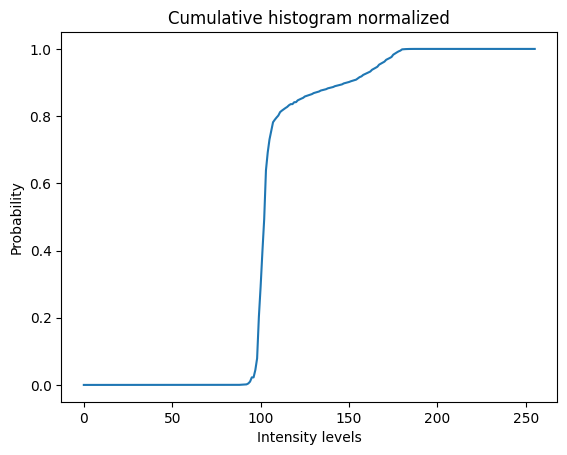

In [13]:
plt.plot(cdf_einstein)
plt.xlabel('Intensity levels')
plt.ylabel('Probability')
plt.title('Cumulative histogram normalized')
plt.show()

## Paso 2: Calcule la LUT de la transformación

In [14]:
lut = np.round(cdf_einstein * (256 - 1)).astype(int)

lut

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   1,   2,   6,   6,  11,  20,  52,  75, 101, 126, 163,
       176, 186, 193, 199, 201, 203, 204, 207, 208, 209, 210, 211, 212,
       213, 213, 215, 215, 216, 217, 217, 218, 219, 219, 220, 220, 221,
       221, 222, 222, 223, 223, 224, 224, 224, 225, 225, 226, 226, 227,
       227, 227, 228, 228, 229, 229, 230, 230, 230, 231, 231, 232, 233,
       234, 234, 235, 236, 237, 237, 238, 239, 240, 241, 241, 243, 244,
       245, 245, 247, 247, 248, 249, 251, 252, 252, 253, 254, 25

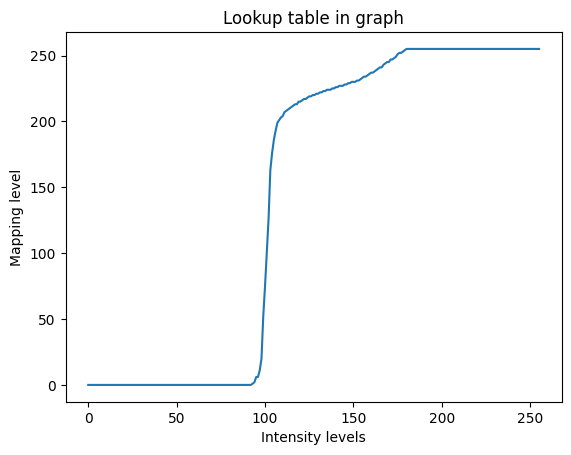

In [15]:
plt.plot(lut)
plt.xlabel('Intensity levels')
plt.ylabel('Mapping level')
plt.title('Lookup table in graph')
plt.show()

## Paso 3: Aplique la Transformación

Hacemos el conteo de cada uno de los valores únicos que son nuestro niveles de mapeo. Luego, sumamos sus correspondientes valores con los conteos (frecuencias) de los niveles de intensidad de la imagen original.

In [16]:
mapping_level_unique = np.unique(lut)
mapping_level_count = []
for i in range(mapping_level_unique.shape[0]):
    mask = lut[:] == mapping_level_unique[i]
    mapping = frec_einstein[mask]
    mapping_level_count.append(np.sum(mapping))

mapping_transform = np.column_stack((mapping_level_unique, np.array(mapping_level_count)))

In [17]:
mapped_pixels = []
for i in range(einstein_vec.shape[0]):
    mapped_pixels.append(lut[einstein_vec[i]])

einstein_manual_eq = np.array(mapped_pixels).reshape(einstein.shape[0], einstein.shape[1])

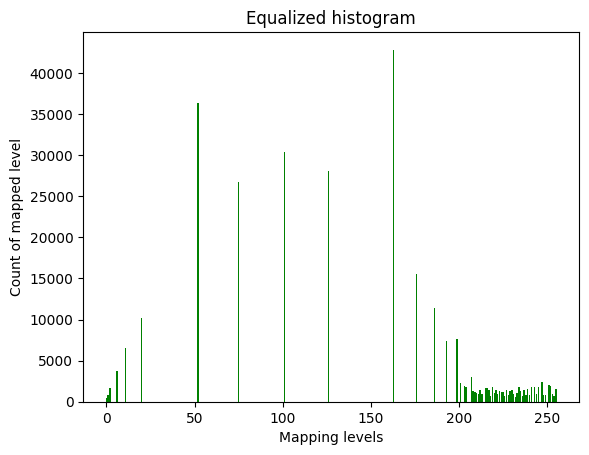

In [18]:
plt.bar(mapping_transform[:, 0], mapping_transform[:, 1], color='green')
plt.xlabel('Mapping levels')
plt.ylabel('Count of mapped level')
plt.title('Equalized histogram')
plt.show()

## Paso 4: Grafique su resultado y comparelo con la original y la ecualizada automáticamente

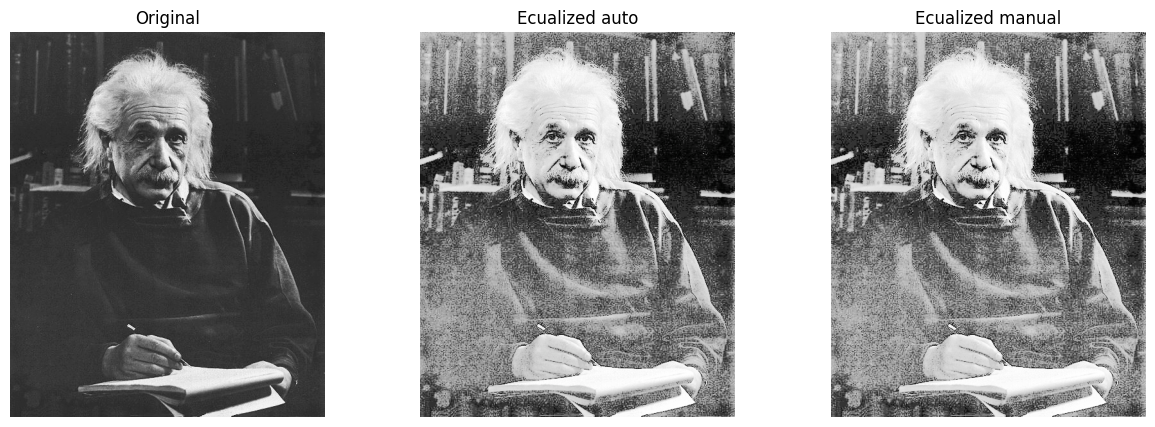

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(einstein, cmap = 'gray')
plt.axis('off')
plt.title('Original')
plt.subplot(1, 3, 2)
plt.imshow(hist_eq_img, cmap = 'gray')
plt.axis('off')
plt.title('Ecualized auto')
plt.subplot(1, 3, 3)
plt.imshow(einstein_manual_eq, cmap = 'gray')
plt.axis('off')
plt.title('Ecualized manual')
plt.show()

# Estiramiento del contraste (Contrast Stretching)

![ContrastStretch](https://www.tutorialspoint.com/dip/images/stretching3.jpg)

# Reto No. 2: Implementa el estiramiento de contraste y compara con la ecualizada

In [20]:
I = l
Imin = np.min(einstein_vec)
Imax = np.max(einstein_vec)
Is = np.subtract(einstein_vec, Imin) / (Imax - Imin)
Is = Is * (2 ** 8)

Is = Is.reshape(einstein.shape[0], einstein.shape[1])

Text(0.5, 1.0, 'Histogram')

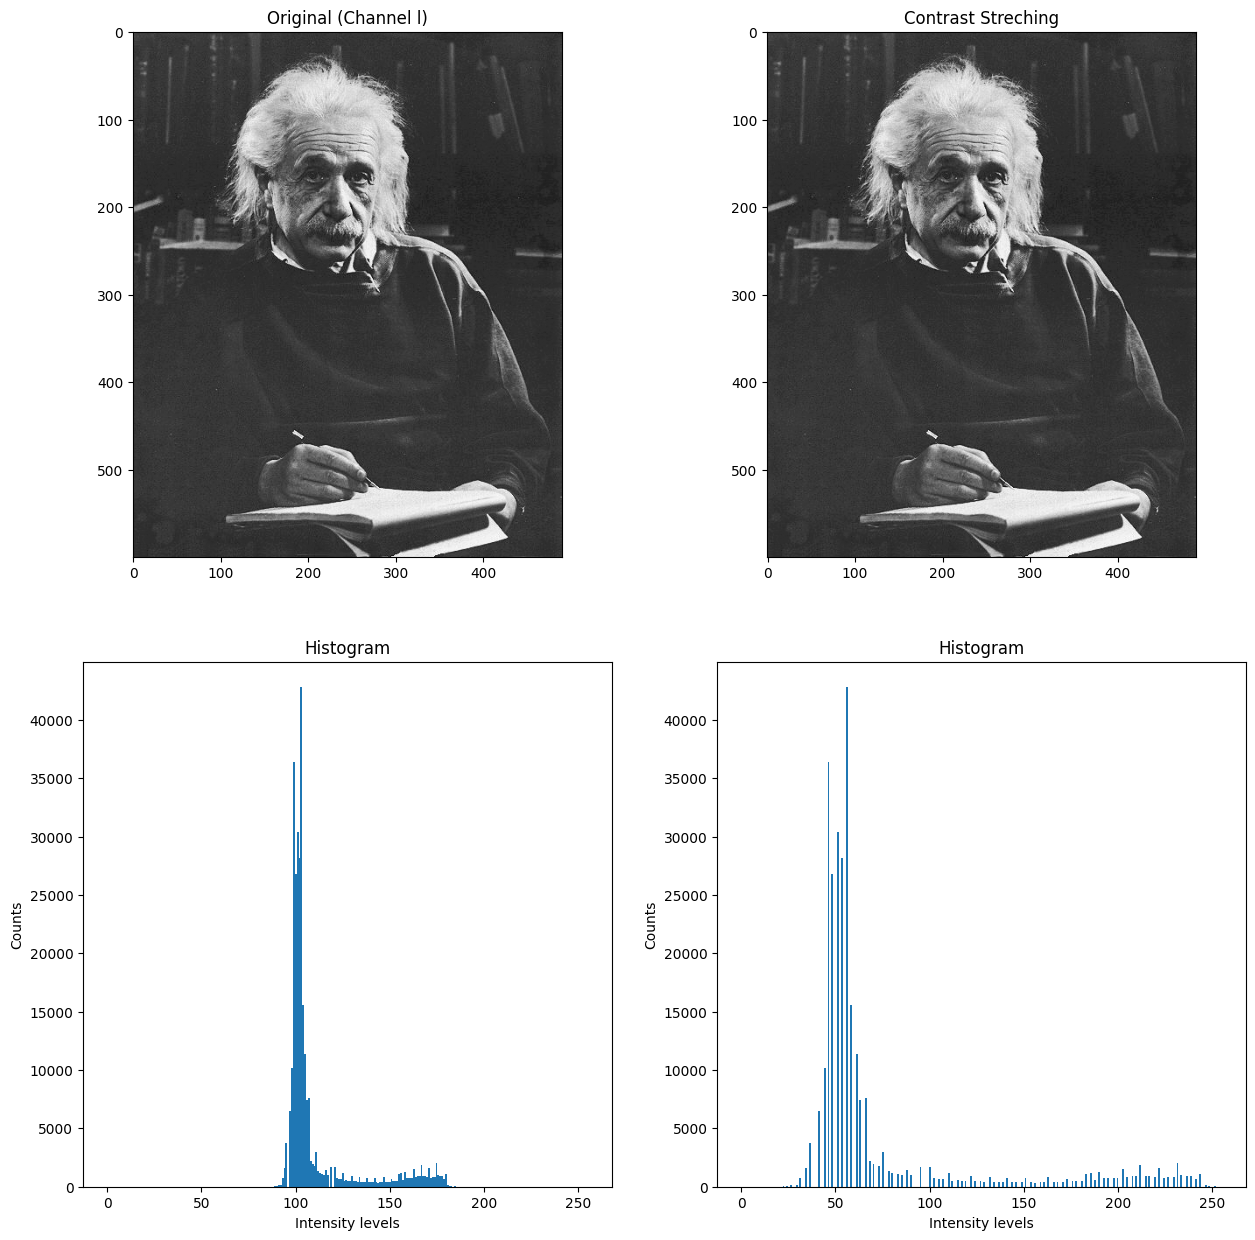

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(einstein, cmap='gray')
plt.title('Original (Channel l)')
plt.subplot(223)
plt.hist(einstein.ravel(), bins=256, range=(0,255))
plt.xlabel('Intensity levels')
plt.ylabel('Counts')
plt.title('Histogram')

plt.subplot(222)
plt.imshow(Is, cmap='gray')
plt.title('Contrast Streching')
plt.subplot(224)
plt.hist(Is.ravel(), bins=256, range=(0,255))
plt.xlabel('Intensity levels')
plt.ylabel('Counts')
plt.title('Histogram')

# Diferencia entre Estiramiento de Contraste y Ecualización del Histograma?

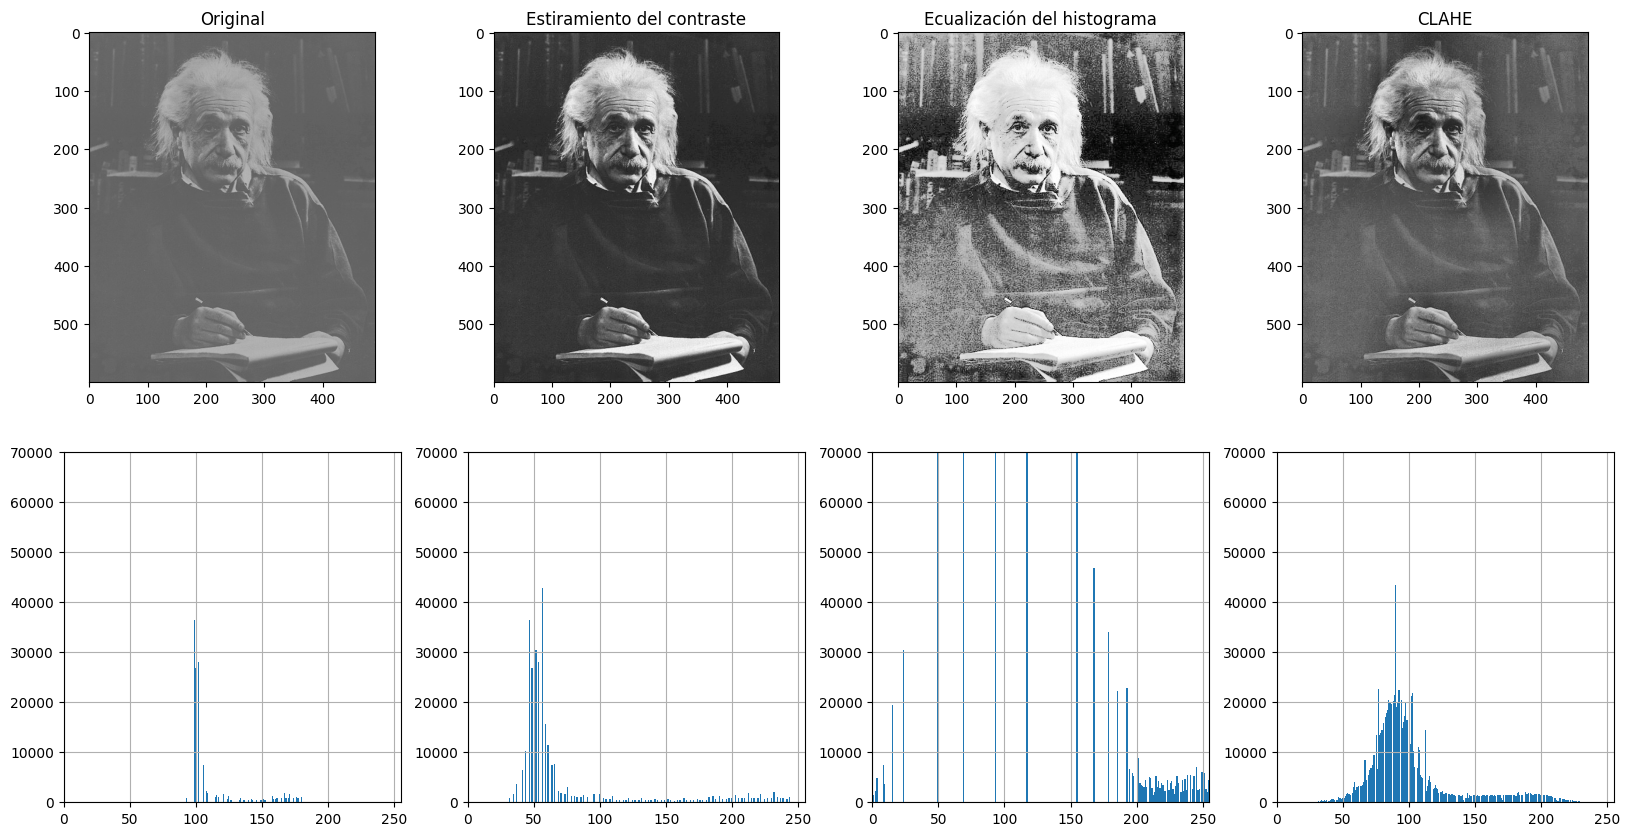

In [22]:
# Plot
plt.figure(figsize=(20,10))
plt.subplot(241), plt.imshow(I,'gray',vmin=0, vmax=255), plt.title('Original')
plt.subplot(242), plt.imshow(Is,'gray',vmin=0, vmax=255), plt.title('Estiramiento del contraste')
plt.subplot(243), plt.imshow(hist_eq_img,'gray',vmin=0, vmax=255), plt.title('Ecualización del histograma')
plt.subplot(244), plt.imshow(CLAHE_img,'gray',vmin=0, vmax=255), plt.title('CLAHE')
plt.subplot(245), plt.hist(I.ravel(),256), plt.axis([0,255,0,70e3]), plt.grid(True)
plt.subplot(246), plt.hist(Is.ravel(),256), plt.axis([0,255,0,70e3]), plt.grid(True);
plt.subplot(247), plt.hist(hist_eq_img.ravel(),256), plt.axis([0,255,0,70e3]), plt.grid(True);
plt.subplot(248), plt.hist(CLAHE_img.ravel(),256), plt.axis([0,255,0,70e3]), plt.grid(True);

# Preguntas


*   ¿Cuál crees que es la diferencia entre "estiramiento" y "ecualización" del histograma?
*   Investiga sobre AHE y CLAHE. ¿Cuáles son las diferencias?


